<a href="https://colab.research.google.com/github/cabrera21hub/colab_Proyect/blob/main/Prediccion_de_modelo_de_calidad_de_aire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

fecha    0
CO       0
NO       0
NO2      0
NOX      0
O3       0
PM10     0
PM25     0
SO2      0
dtype: int64


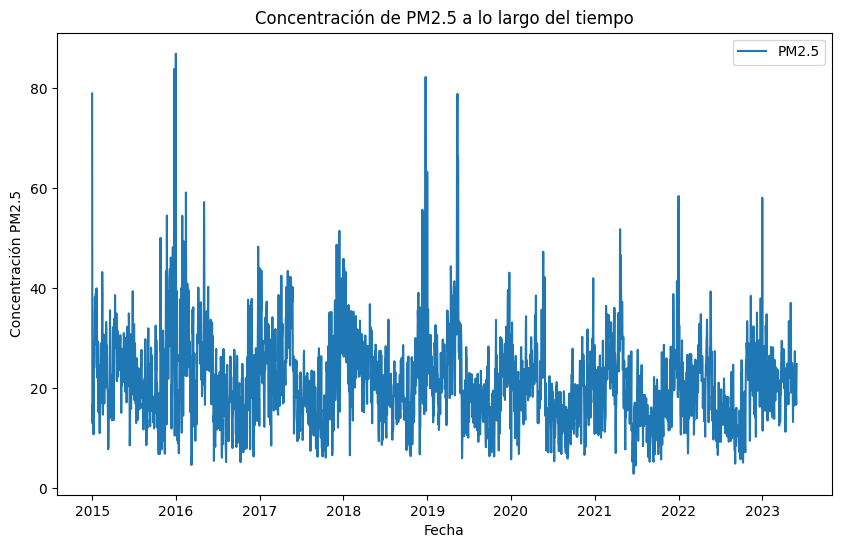

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos
df = pd.read_csv('/content/rama_2023_05.csv')

# Convertir la columna 'fecha' a datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Comprobar si hay valores nulos
print(df.isnull().sum())

# Eliminar filas con valores nulos (opcional)
df = df.dropna()

# Análisis exploratorio (gráficos)
plt.figure(figsize=(10, 6))
plt.plot(df['fecha'], df['PM25'], label='PM2.5')
plt.xlabel('Fecha')
plt.ylabel('Concentración PM2.5')
plt.title('Concentración de PM2.5 a lo largo del tiempo')
plt.legend()
plt.show()


In [10]:
from sklearn.model_selection import train_test_split

# Seleccionar características (X) y variable objetivo (y)
#Seleccionamos las columnas relevantes para predecir la calidad del aire (PM2.5 en este caso)
# y las características predictoras.
X = df[['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2']]
y = df['PM25']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
from sklearn.preprocessing import StandardScaler

# Escalar los datos,para que tengan una escala comun los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Entrenar el modelo SVR
svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred = svr.predict(X_test_scaled)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'RMSE: {rmse}')


RMSE: 4.282760574681629


In [13]:
from sklearn.model_selection import GridSearchCV

# Definir el grid de parámetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Configurar Grid Search
grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=2)
grid.fit(X_train_scaled, y_train)

# Mostrar los mejores parámetros
print(f'Mejores parámetros: {grid.best_params_}')

# Realizar predicciones con el mejor modelo
y_pred_optimized = grid.predict(X_test_scaled)

# Evaluar el modelo optimizado
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
rmse_optimized = mse_optimized ** 0.5
print(f'RMSE Optimizado: {rmse_optimized}')


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.4s
[CV] END ......................C=0.1, gamma=0.01

In [14]:
# Agregar nuevas características al DataFrame original (ejemplos)
df['NO2/NO'] = df['NO2'] / df['NO']
df['NOX/NO'] = df['NOX'] / df['NO']

# Actualizar X con las nuevas características
X = df[['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2', 'NO2/NO', 'NOX/NO']]

# Dividir y escalar los datos nuevamente
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
from sklearn.ensemble import RandomForestRegressor

# Entrenar un modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Realizar predicciones
y_pred_rf = rf.predict(X_test)

# Evaluar el modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
print(f'RMSE Random Forest: {rmse_rf}')


RMSE Random Forest: 3.7696078918309457


In [16]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el grid de parámetros para la búsqueda
param_grid_rf = {
    'n_estimators': [100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurar y ejecutar Randomized Search
rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_grid_rf,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

# Mostrar los mejores parámetros
print(f'Mejores parámetros: {rf_random.best_params_}')

# Realizar predicciones con el mejor modelo
y_pred_rf_optimized = rf_random.predict(X_test)

# Evaluar el modelo optimizado
mse_rf_optimized = mean_squared_error(y_test, y_pred_rf_optimized)
rmse_rf_optimized = mse_rf_optimized ** 0.5
print(f'RMSE Optimizado Random Forest: {rmse_rf_optimized}')


Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

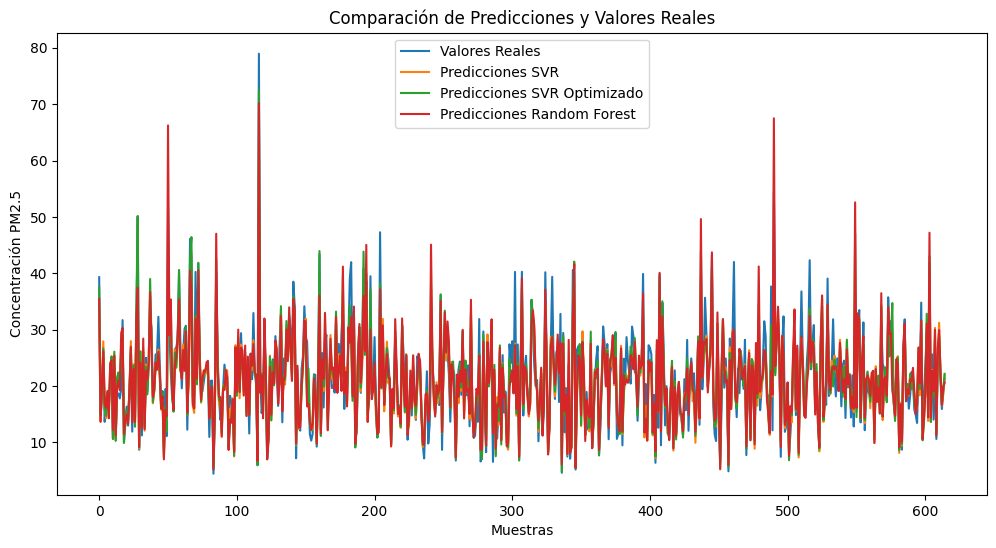

In [17]:
import matplotlib.pyplot as plt

# Comparar predicciones con los valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Valores Reales')
plt.plot(y_pred, label='Predicciones SVR')
plt.plot(y_pred_optimized, label='Predicciones SVR Optimizado')
plt.plot(y_pred_rf, label='Predicciones Random Forest')
plt.xlabel('Muestras')
plt.ylabel('Concentración PM2.5')
plt.title('Comparación de Predicciones y Valores Reales')
plt.legend()
plt.show()


fecha    0
CO       0
NO       0
NO2      0
NOX      0
O3       0
PM10     0
PM25     0
SO2      0
dtype: int64


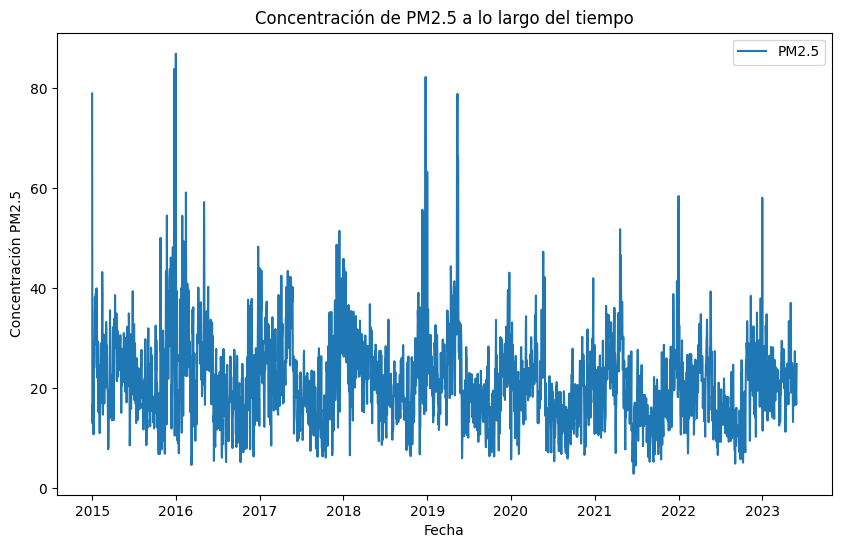

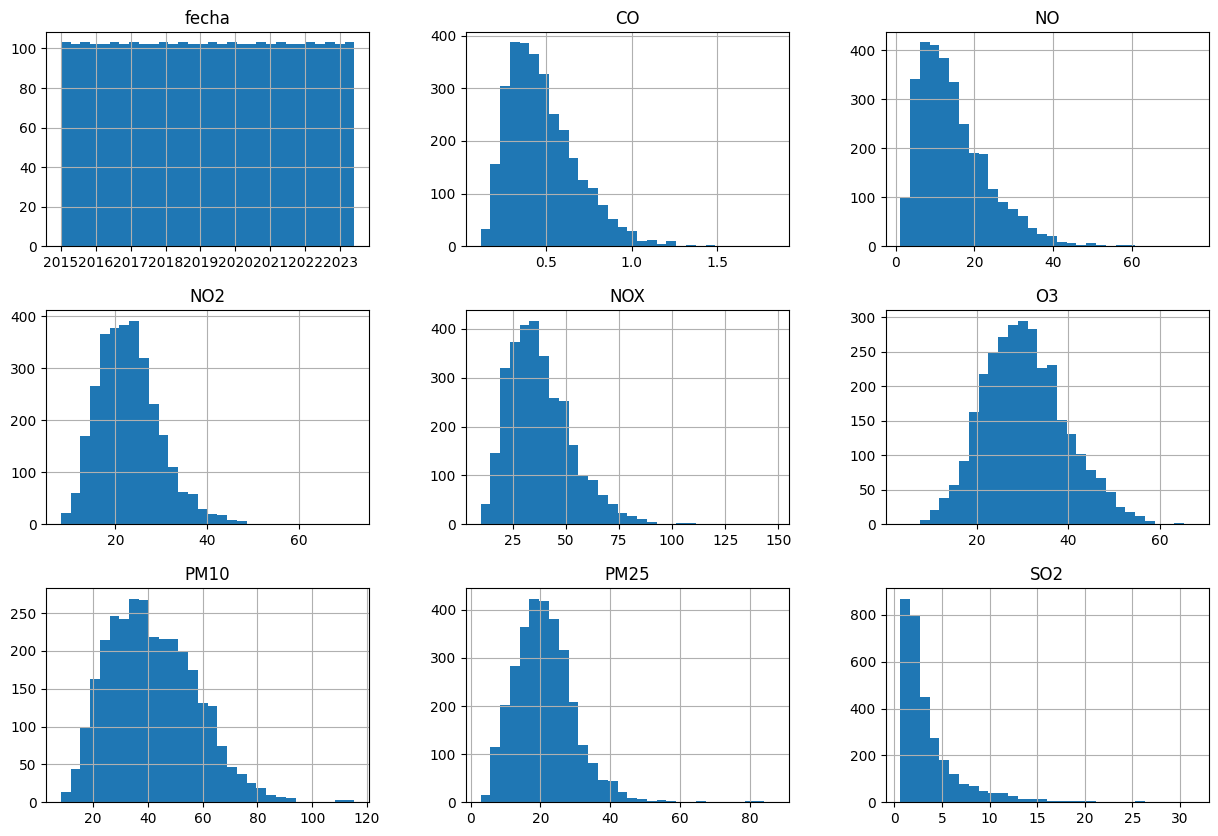

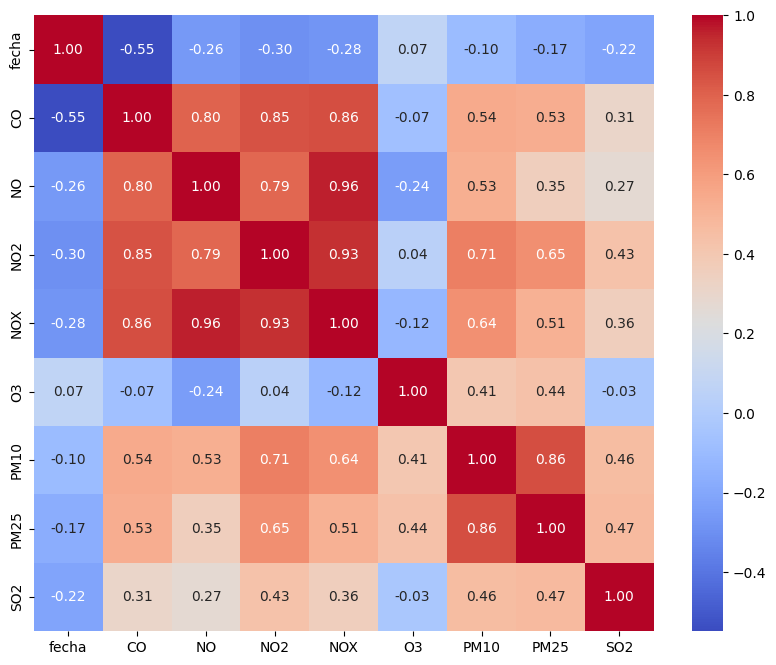

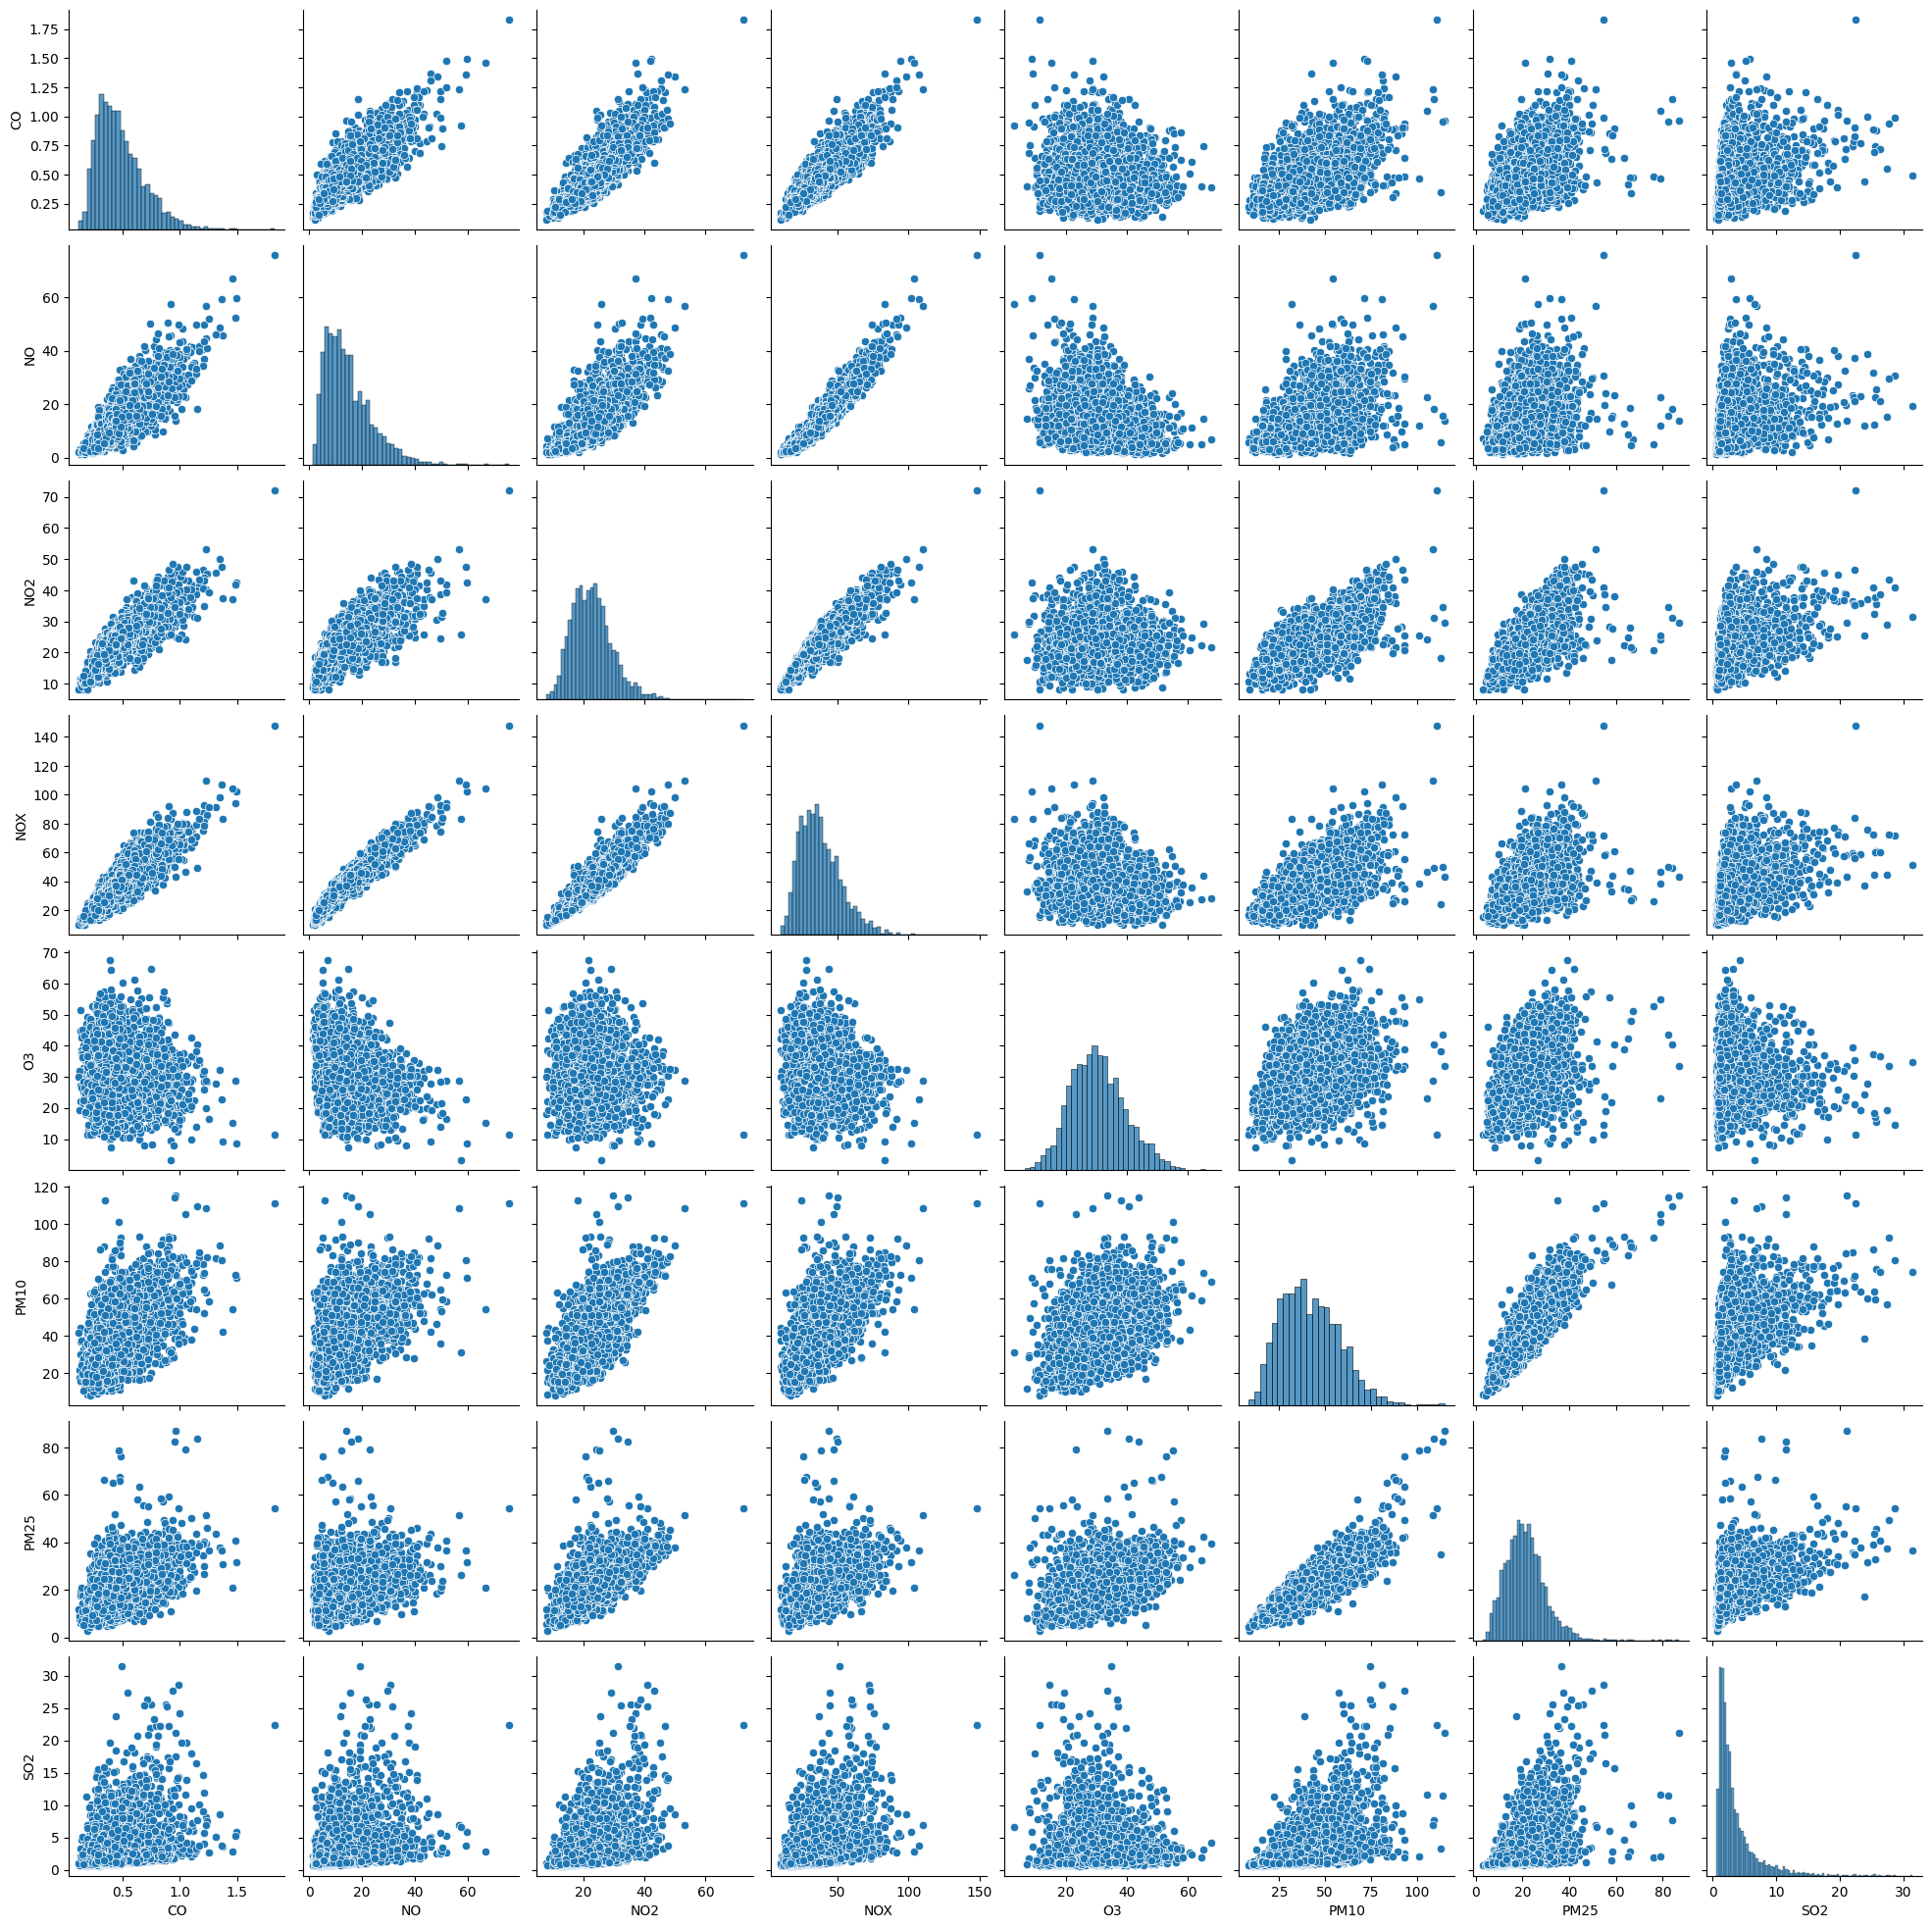

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Importar seaborn para visualización avanzada

# Cargar los datos
df = pd.read_csv('/content/rama_2023_05.csv')

# Convertir la columna 'fecha' a datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Comprobar si hay valores nulos
print(df.isnull().sum())

# Eliminar filas con valores nulos (opcional)
df = df.dropna()

# Análisis exploratorio (gráficos)
plt.figure(figsize=(10, 6))
plt.plot(df['fecha'], df['PM25'], label='PM2.5')
plt.xlabel('Fecha')
plt.ylabel('Concentración PM2.5')
plt.title('Concentración de PM2.5 a lo largo del tiempo')
plt.legend()
plt.show()

# Histogramas
df.hist(bins=30, figsize=(15, 10))
plt.show()

# Matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

# Diagramas de dispersión
sns.pairplot(df)
plt.show()



In [ ]:
# Ejemplo de características nuevas
df['ratio_NO2_NO'] = df['NO2'] / df['NO']
df['ratio_NOX_NO'] = df['NOX'] / df['NO']


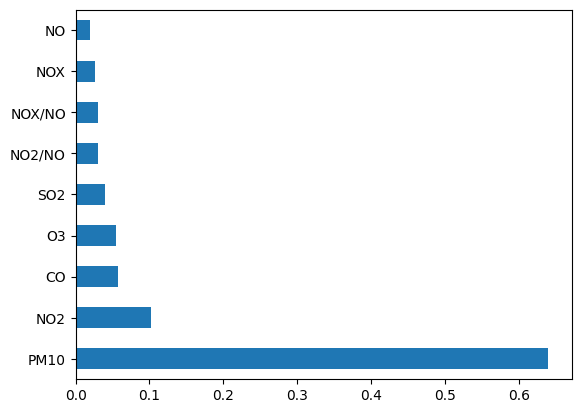

In [19]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
model.fit(X, y)

# Mostrar importancia de características
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()


In [30]:
from sklearn.ensemble import GradientBoostingRegressor

# Entrenar modelo Gradient Boosting
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train_scaled, y_train)

# Predicciones
y_pred_gbr = gbr.predict(X_test_scaled)

# Evaluar el modelo
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = mse_gbr ** 0.5
print(f'RMSE Gradient Boosting: {rmse_gbr}')


RMSE Gradient Boosting: 3.7051247386802575


fecha    0
CO       0
NO       0
NO2      0
NOX      0
O3       0
PM10     0
PM25     0
SO2      0
dtype: int64


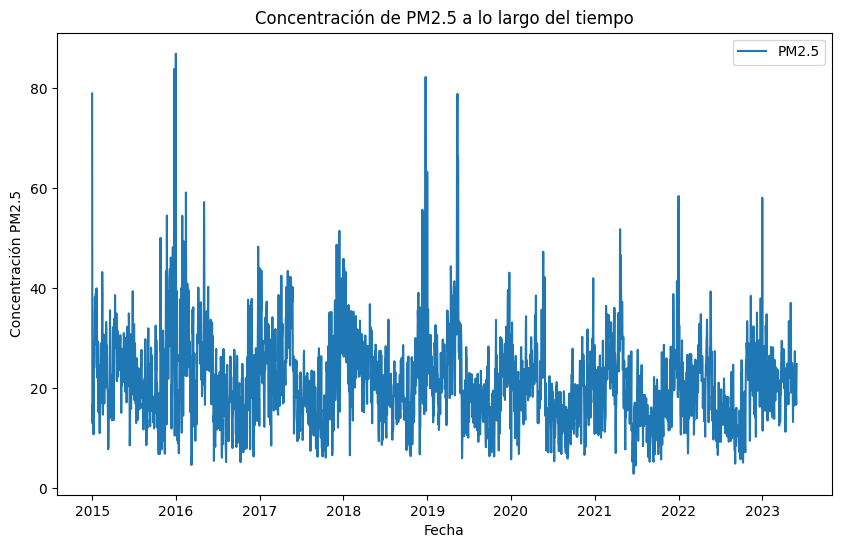

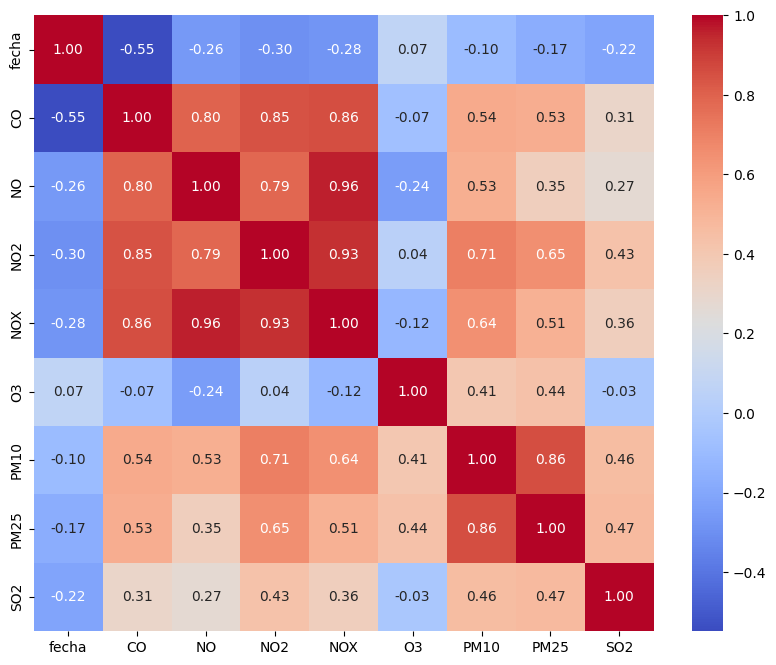

RMSE: 4.221148685909389
RMSE Scores: [6.07247871 3.83574981 5.84866142 3.44334066 3.5151063 ]
RMSE Mean: 4.543067380798805
RMSE Standard Deviation: 1.1670540525649922


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Cargar los datos
df = pd.read_csv('/content/rama_2023_05.csv')

# Convertir la columna 'fecha' a datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Comprobar si hay valores nulos
print(df.isnull().sum())

# Eliminar filas con valores nulos (opcional)
df = df.dropna()

# Análisis exploratorio (gráficos)
plt.figure(figsize=(10, 6))
plt.plot(df['fecha'], df['PM25'], label='PM2.5')
plt.xlabel('Fecha')
plt.ylabel('Concentración PM2.5')
plt.title('Concentración de PM2.5 a lo largo del tiempo')
plt.legend()
plt.show()

# Matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

# Seleccionar características (X) y variable objetivo (y)
X = df[['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2']]
y = df['PM25']

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo SVR
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)

# Realizar predicciones
y_pred = svr.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'RMSE: {rmse}')

# Validación cruzada para SVR
scores = cross_val_score(svr, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print(f'RMSE Scores: {rmse_scores}')
print(f'RMSE Mean: {rmse_scores.mean()}')
print(f'RMSE Standard Deviation: {rmse_scores.std()}')



fecha    0
CO       0
NO       0
NO2      0
NOX      0
O3       0
PM10     0
PM25     0
SO2      0
dtype: int64


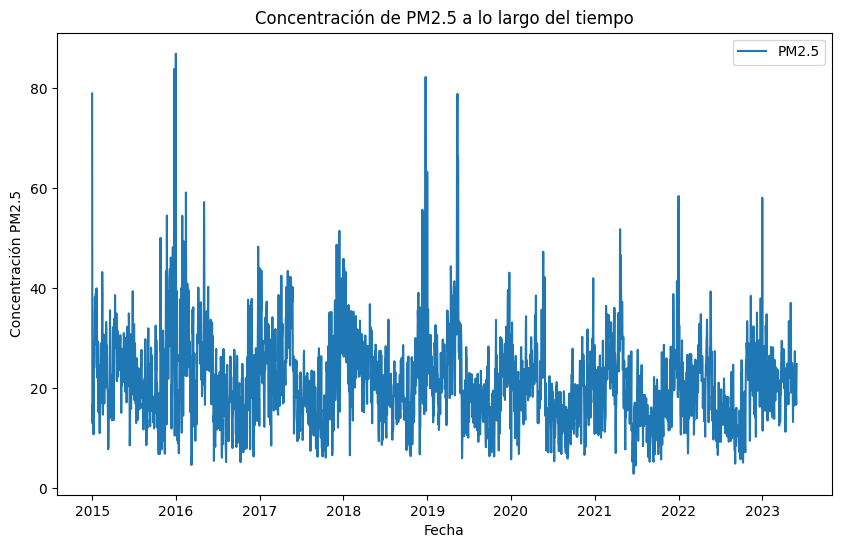

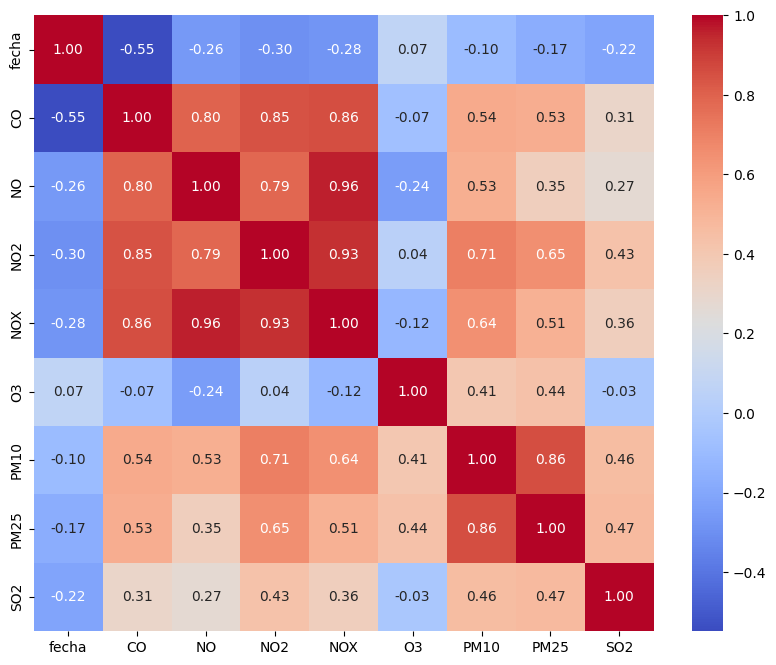

RMSE: 4.228147370837359
RMSE Scores: [5.95251284 3.831374   5.8760156  3.6779851  3.50730015]
RMSE Mean: 4.569037537272602
RMSE Standard Deviation: 1.10341323129723
RMSE Cross-Validation Predictions: 4.701021049973912


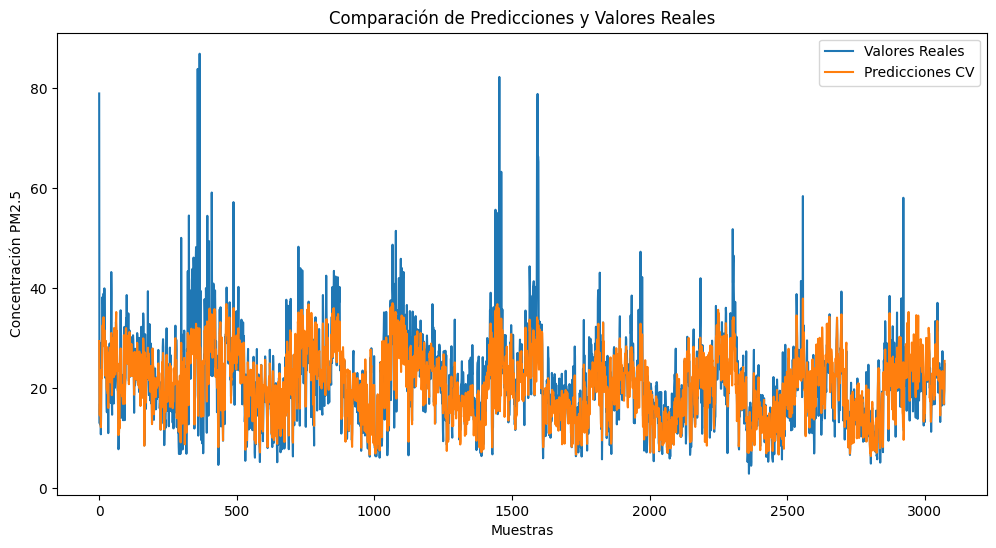

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar los datos
df = pd.read_csv('/content/rama_2023_05.csv')

# Convertir la columna 'fecha' a datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Comprobar si hay valores nulos
print(df.isnull().sum())

# Eliminar filas con valores nulos (opcional)
df = df.dropna()

# Análisis exploratorio (gráficos)
plt.figure(figsize=(10, 6))
plt.plot(df['fecha'], df['PM25'], label='PM2.5')
plt.xlabel('Fecha')
plt.ylabel('Concentración PM2.5')
plt.title('Concentración de PM2.5 a lo largo del tiempo')
plt.legend()
plt.show()

# Matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

# Seleccionar características (X) y variable objetivo (y)
df['NO2/NO'] = df['NO2'] / df['NO']
df['NOX/NO'] = df['NOX'] / df['NO']
X = df[['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2', 'NO2/NO', 'NOX/NO']]
y = df['PM25']

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo SVR
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)

# Realizar predicciones
y_pred = svr.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'RMSE: {rmse}')

# Validación cruzada para SVR
scores = cross_val_score(svr, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print(f'RMSE Scores: {rmse_scores}')
print(f'RMSE Mean: {rmse_scores.mean()}')
print(f'RMSE Standard Deviation: {rmse_scores.std()}')

# Predicciones de validación cruzada
y_pred_cv = cross_val_predict(svr, X_scaled, y, cv=5)
mse_cv = mean_squared_error(y, y_pred_cv)
rmse_cv = mse_cv ** 0.5
print(f'RMSE Cross-Validation Predictions: {rmse_cv}')

# Comparar predicciones con los valores reales
plt.figure(figsize=(12, 6))
plt.plot(y.values, label='Valores Reales')
plt.plot(y_pred_cv, label='Predicciones CV')
plt.xlabel('Muestras')
plt.ylabel('Concentración PM2.5')
plt.title('Comparación de Predicciones y Valores Reales')
plt.legend()
plt.show()


In [33]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el grid de parámetros
param_dist = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'epsilon': [0.1, 0.2, 0.3, 0.5, 0.8],
    'kernel': ['rbf']
}

# Configurar RandomizedSearchCV
rand_search = RandomizedSearchCV(svr, param_distributions=param_dist, n_iter=50, cv=5, verbose=2, random_state=42, n_jobs=-1)
rand_search.fit(X_train_scaled, y_train)

# Mostrar los mejores parámetros
print(f'Mejores parámetros: {rand_search.best_params_}')

# Realizar predicciones con el mejor modelo
y_pred_rand_optimized = rand_search.predict(X_test_scaled)

# Evaluar el modelo optimizado
mse_rand_optimized = mean_squared_error(y_test, y_pred_rand_optimized)
rmse_rand_optimized = mse_rand_optimized ** 0.5
print(f'RMSE Optimizado con RandomizedSearchCV: {rmse_rand_optimized}')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'kernel': 'rbf', 'gamma': 0.01, 'epsilon': 0.8, 'C': 1000}
RMSE Optimizado con RandomizedSearchCV: 3.268307438509913


In [27]:
import xgboost as xgb

# Crear y entrenar el modelo
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred_xgb = xg_reg.predict(X_test_scaled)

# Evaluar el modelo
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
print(f'RMSE XGBoost: {rmse_xgb}')


RMSE XGBoost: 4.150113933470165


In [28]:
# Promedio de las predicciones de SVR y XGBoost
y_pred_ensemble = (y_pred + y_pred_xgb) / 2

# Evaluar el modelo de ensamble
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
rmse_ensemble = mse_ensemble ** 0.5
print(f'RMSE Ensamble: {rmse_ensemble}')


RMSE Ensamble: 4.0628215808536945


1. feature PM10 (0.7934877559833919)
2. feature NO2 (0.04167837557218908)
3. feature O3 (0.03865113859759396)
4. feature SO2 (0.02966428648211207)
5. feature CO (0.028255430388989002)
6. feature NO2/NO (0.026875839379716566)
7. feature NOX/NO (0.018125175494227676)
8. feature NOX (0.012333795438184192)
9. feature NO (0.010928202663595525)


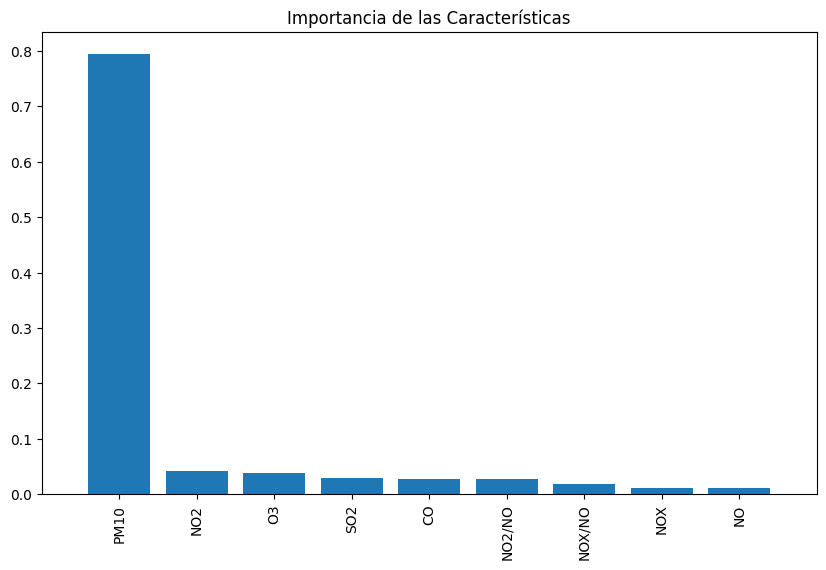

In [34]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Imprimir la importancia de las características
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.title("Importancia de las Características")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


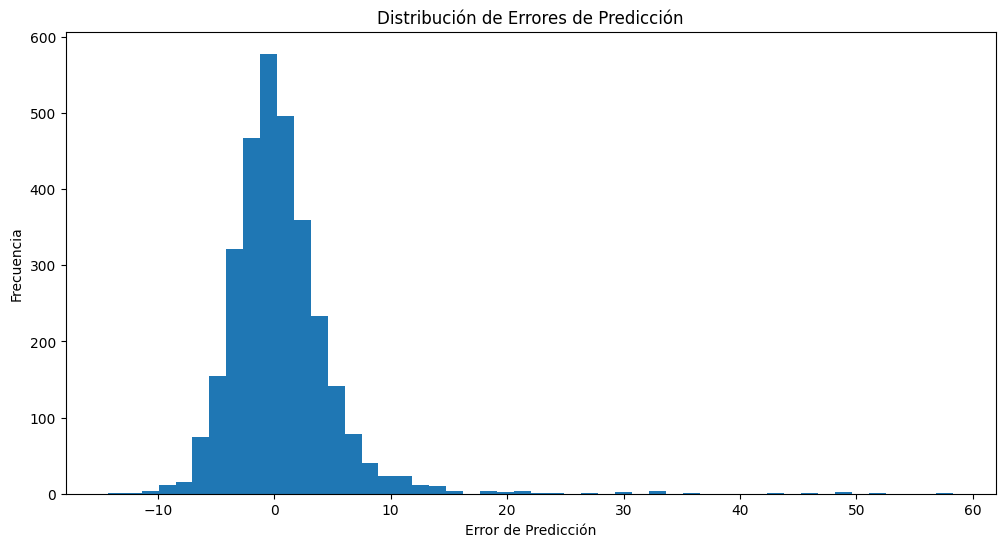

In [35]:
# Predicciones de validación cruzada para análisis de errores
y_pred_cv = cross_val_predict(svr, X_scaled, y, cv=5)

# Análisis de errores
errors = y - y_pred_cv
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50)
plt.xlabel("Error de Predicción")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores de Predicción")
plt.show()


In [36]:
import joblib

# Guardar el modelo optimizado
joblib.dump(rand_search.best_estimator_, 'best_svr_model_optimized.pkl')


['best_svr_model_optimized.pkl']

In [37]:
# Predicciones en el conjunto de entrenamiento
y_train_pred = rand_search.predict(X_train_scaled)

# Evaluar en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = mse_train ** 0.5
print(f'RMSE en el conjunto de entrenamiento: {rmse_train}')


RMSE en el conjunto de entrenamiento: 3.276359762267055


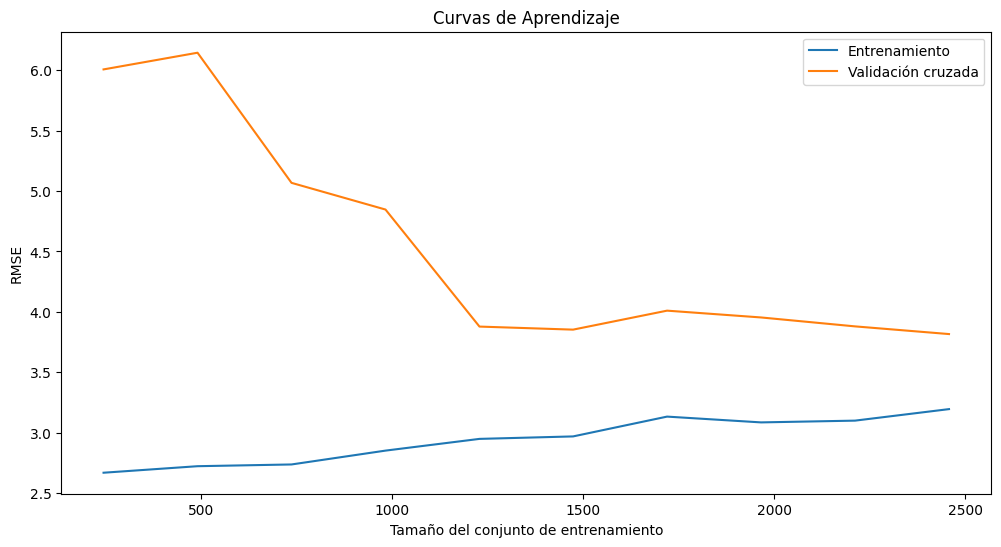

In [38]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rand_search.best_estimator_, X_scaled, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, np.sqrt(train_scores_mean), label='Entrenamiento')
plt.plot(train_sizes, np.sqrt(test_scores_mean), label='Validación cruzada')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.title('Curvas de Aprendizaje')
plt.legend()
plt.show()


1. feature PM10 (0.7934877559833919)
2. feature NO2 (0.04167837557218908)
3. feature O3 (0.03865113859759396)
4. feature SO2 (0.02966428648211207)
5. feature CO (0.028255430388989002)
6. feature NO2/NO (0.026875839379716566)
7. feature NOX/NO (0.018125175494227676)
8. feature NOX (0.012333795438184192)
9. feature NO (0.010928202663595525)


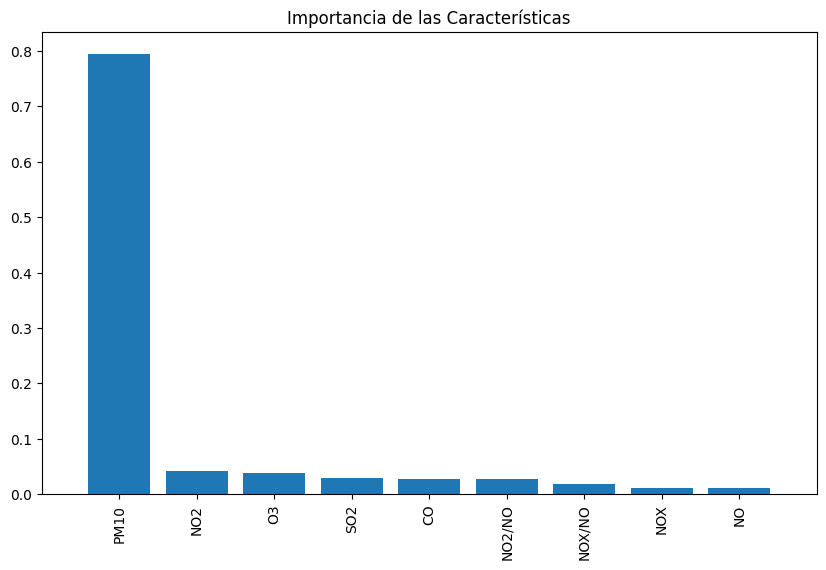

In [39]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Imprimir la importancia de las características
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.title("Importancia de las Características")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


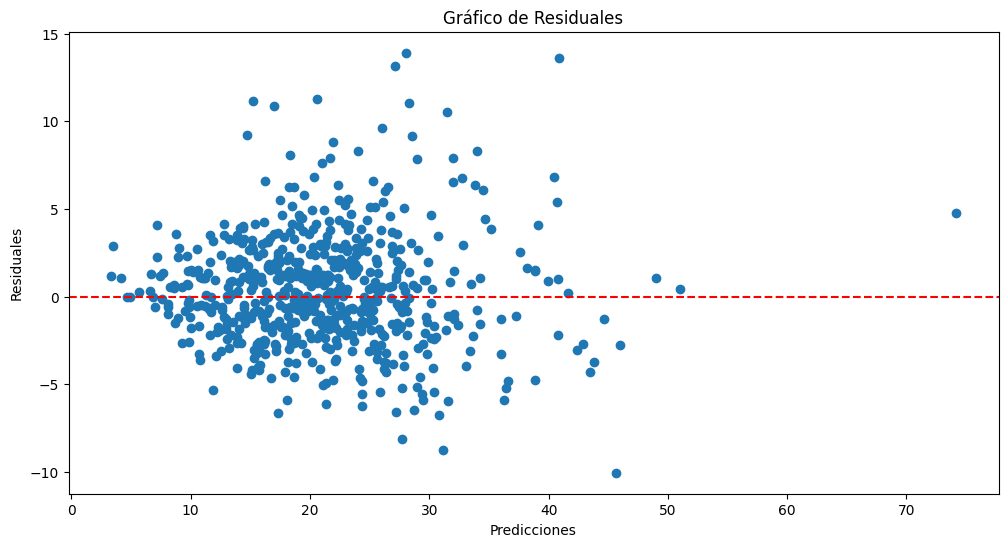

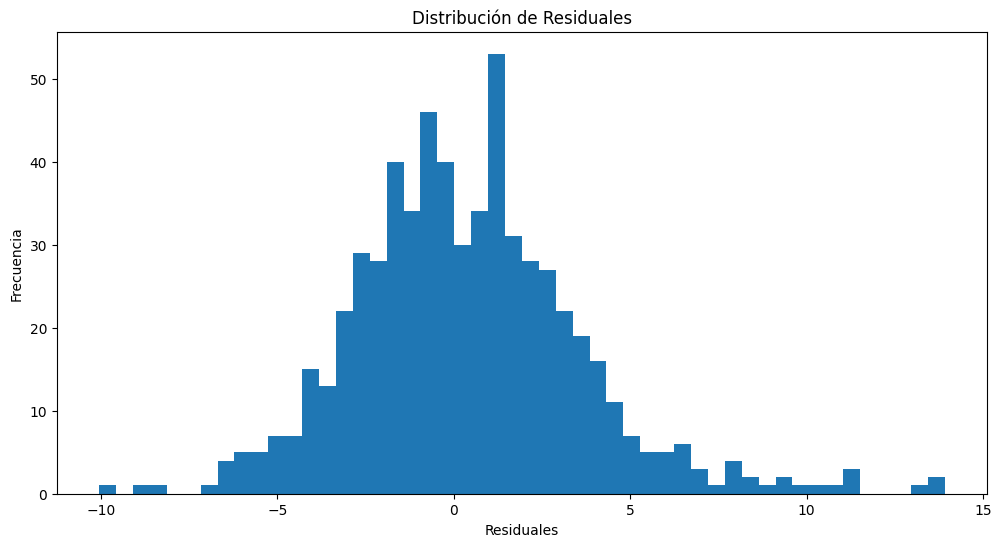

In [40]:
residuals = y_test - y_pred_rand_optimized

plt.figure(figsize=(12, 6))
plt.scatter(y_pred_rand_optimized, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.title('Gráfico de Residuales')
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50)
plt.xlabel('Residuales')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuales')
plt.show()


In [41]:
import joblib

# Guardar el modelo SVR optimizado
joblib.dump(grid.best_estimator_, 'best_svr_model.pkl')

# Guardar el scaler
joblib.dump(scaler, 'scaler.pkl')



['scaler.pkl']

In [42]:
import joblib

# Cargar el modelo SVR optimizado
svr_model = joblib.load('/content/best_svr_model_optimized.pkl')

# Cargar el scaler
scaler = joblib.load('scaler.pkl')


In [44]:
import pandas as pd

# Nuevos datos para predicción (ejemplo)
new_data = pd.DataFrame({
    'CO': [0.3],
    'NO': [0.04],
    'NO2': [0.05],
    'NOX': [0.1],
    'O3': [0.02],
    'PM10': [20],
    'SO2': [0.01],
    'NO2/NO': [0.05/0.04],
    'NOX/NO': [0.1/0.04]
})

# Escalar los nuevos datos
new_data_scaled = scaler.transform(new_data)

# Realizar predicción
new_prediction = svr_model.predict(new_data_scaled)
print(f'Predicción para nuevos datos: {new_prediction}')


Predicción para nuevos datos: [4.62624705]


In [45]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# Cargar el modelo SVR optimizado
svr_model = joblib.load('/content/best_svr_model_optimized.pkl')

# Cargar el scaler
scaler = joblib.load('scaler.pkl')

# Nuevos datos para predicción (ejemplo)
new_data = pd.DataFrame({
    'CO': [0.3],
    'NO': [0.04],
    'NO2': [0.05],
    'NOX': [0.1],
    'O3': [0.02],
    'PM10': [20],
    'SO2': [0.01],
    'NO2/NO': [0.05/0.04],
    'NOX/NO': [0.1/0.04]
})

# Escalar los nuevos datos
new_data_scaled = scaler.transform(new_data)

# Realizar predicción
new_prediction = svr_model.predict(new_data_scaled)
print(f'Predicción para nuevos datos: {new_prediction}')


Predicción para nuevos datos: [4.62624705]


In [46]:
# Realizar predicciones en el conjunto de prueba
y_pred_test = svr_model.predict(X_test_scaled)

# Comparar con los valores reales
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
print(comparison_df.head(10))  # Mostrar las primeras 10 filas para comparar


         Actual  Predicted
2697  39.310105  42.353719
1756  14.307453  14.003032
2529  18.236842  19.014922
194   25.965116  27.639553
240   13.650246  16.143358
2789  17.983051  15.132407
2007  18.174497  17.829327
2028  16.201258  15.225109
1874  20.971867  21.730463
1910  22.657658  25.355109


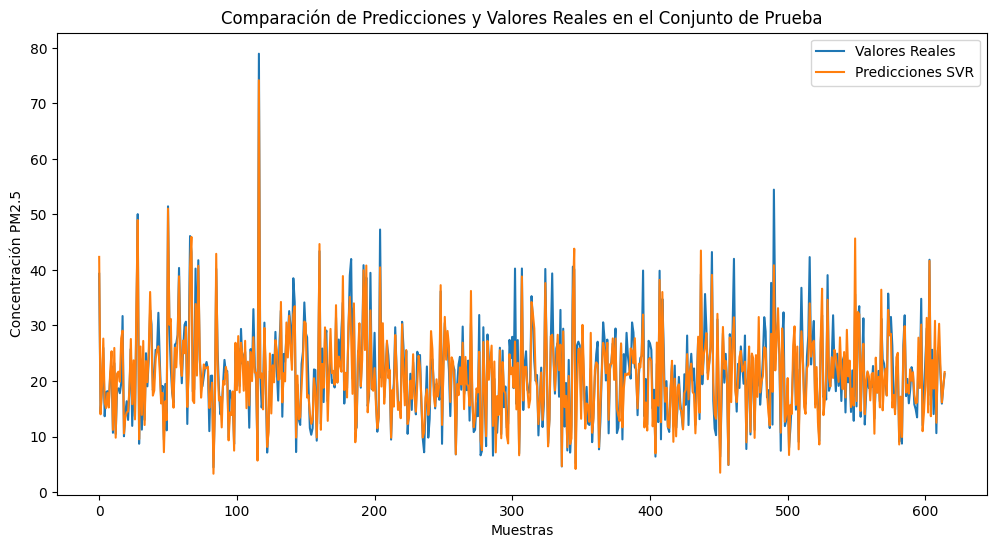

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Valores Reales')
plt.plot(y_pred_test, label='Predicciones SVR')
plt.xlabel('Muestras')
plt.ylabel('Concentración PM2.5')
plt.title('Comparación de Predicciones y Valores Reales en el Conjunto de Prueba')
plt.legend()
plt.show()


In [48]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calcular RMSE
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_test ** 0.5

# Calcular MAE
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calcular R^2
r2_test = r2_score(y_test, y_pred_test)

print(f'RMSE: {rmse_test}')
print(f'MAE: {mae_test}')
print(f'R^2: {r2_test}')


RMSE: 3.268307438509913
MAE: 2.4663717566706436
R^2: 0.8535284986936499


RMSE: 3.268307438509913
MAE: 2.4663717566706436
R^2: 0.8535284986936499


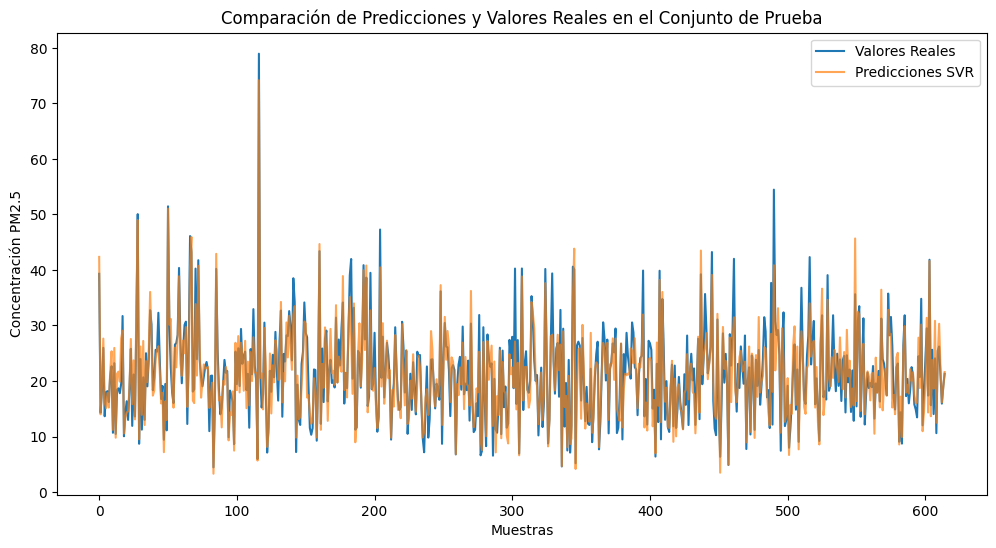

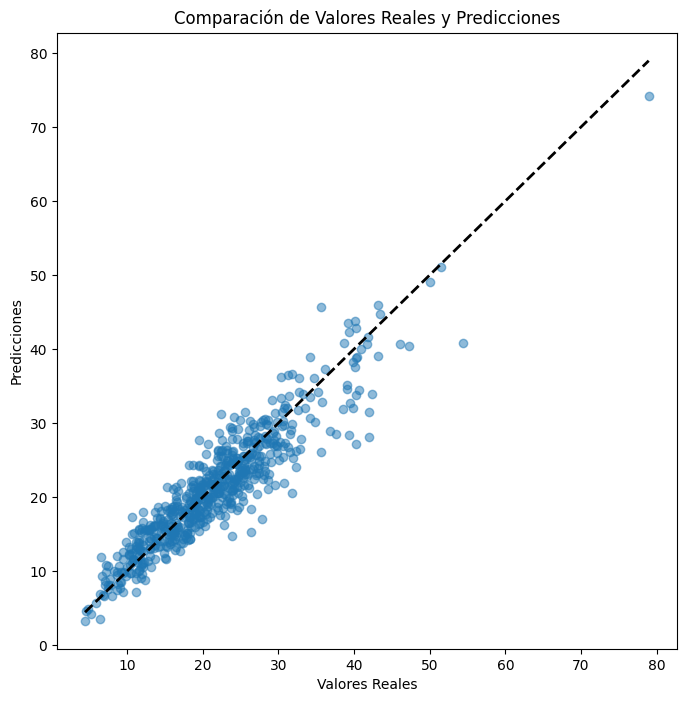

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular métricas de rendimiento
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f'RMSE: {rmse_test}')
print(f'MAE: {mae_test}')
print(f'R^2: {r2_test}')

# Visualizar las predicciones vs. los valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Valores Reales')
plt.plot(y_pred_test, label='Predicciones SVR', alpha=0.7)
plt.xlabel('Muestras')
plt.ylabel('Concentración PM2.5')
plt.title('Comparación de Predicciones y Valores Reales en el Conjunto de Prueba')
plt.legend()
plt.show()

# Scatter plot para comparar valores reales y predichos
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Valores Reales y Predicciones')
plt.show()


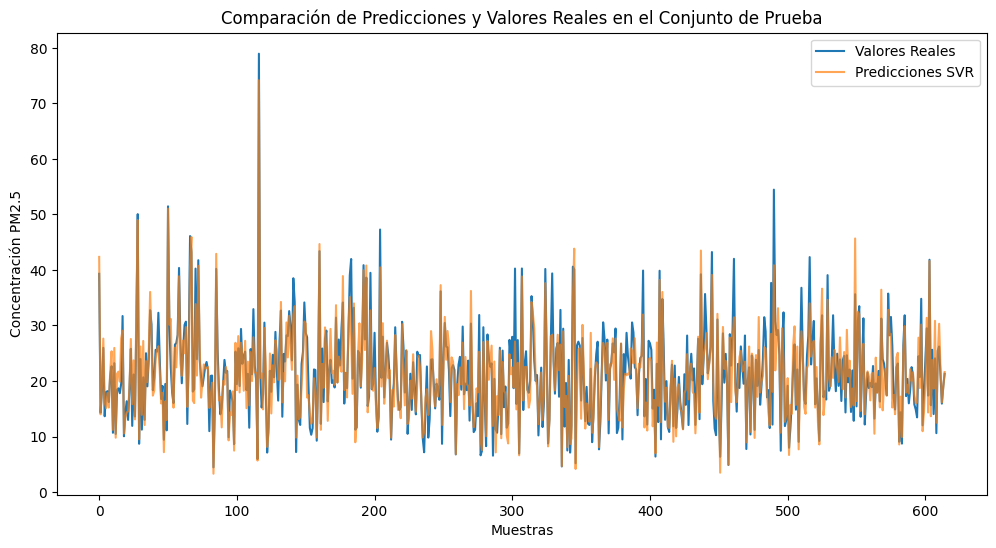

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Valores Reales')
plt.plot(y_pred_test, label='Predicciones SVR', alpha=0.7)
plt.xlabel('Muestras')
plt.ylabel('Concentración PM2.5')
plt.title('Comparación de Predicciones y Valores Reales en el Conjunto de Prueba')
plt.legend()
plt.show()


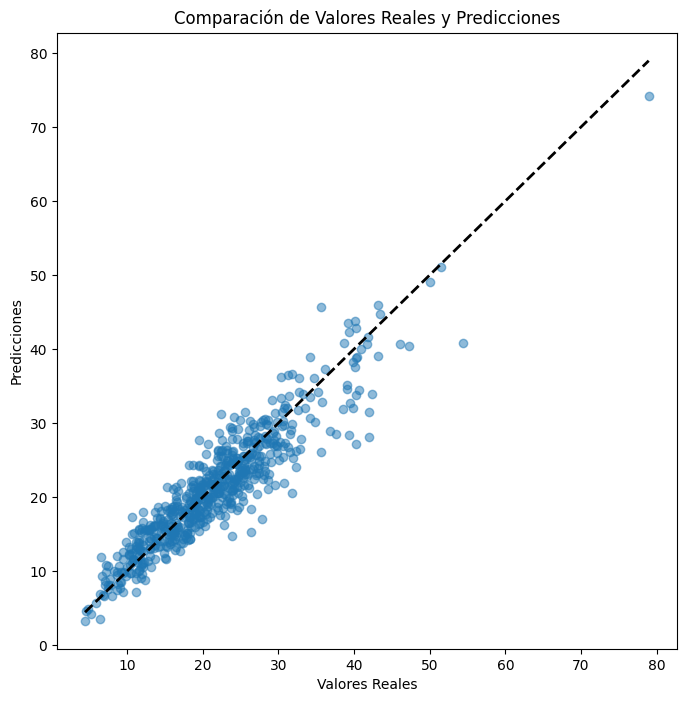

In [51]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Valores Reales y Predicciones')
plt.show()


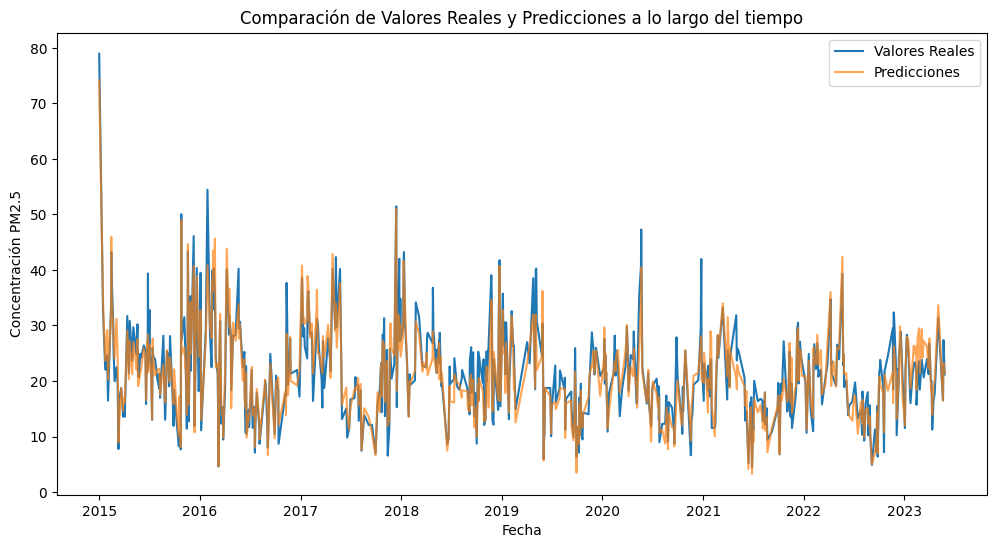

In [52]:
import matplotlib.pyplot as plt

# Suponiendo que 'fecha' es la columna de fechas y 'y_test' es la serie de valores reales
# Crear un DataFrame para combinar las fechas con los valores reales y predicciones
comparison_df = pd.DataFrame({
    'Fecha': df['fecha'].iloc[y_test.index],
    'Actual': y_test.values,
    'Predicted': y_pred_test
})

# Ordenar el DataFrame por fecha
comparison_df = comparison_df.sort_values('Fecha')

# Graficar los valores reales y predicciones a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Fecha'], comparison_df['Actual'], label='Valores Reales')
plt.plot(comparison_df['Fecha'], comparison_df['Predicted'], label='Predicciones', alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Concentración PM2.5')
plt.title('Comparación de Valores Reales y Predicciones a lo largo del tiempo')
plt.legend()
plt.show()


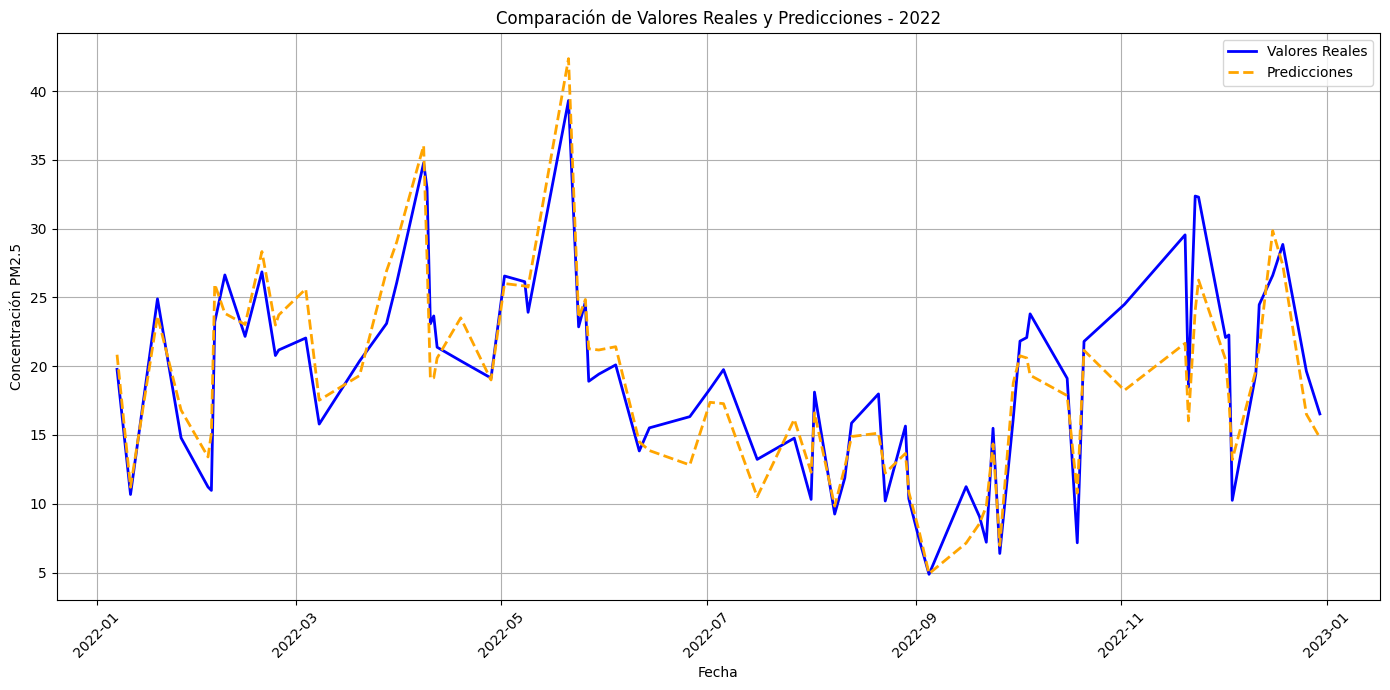

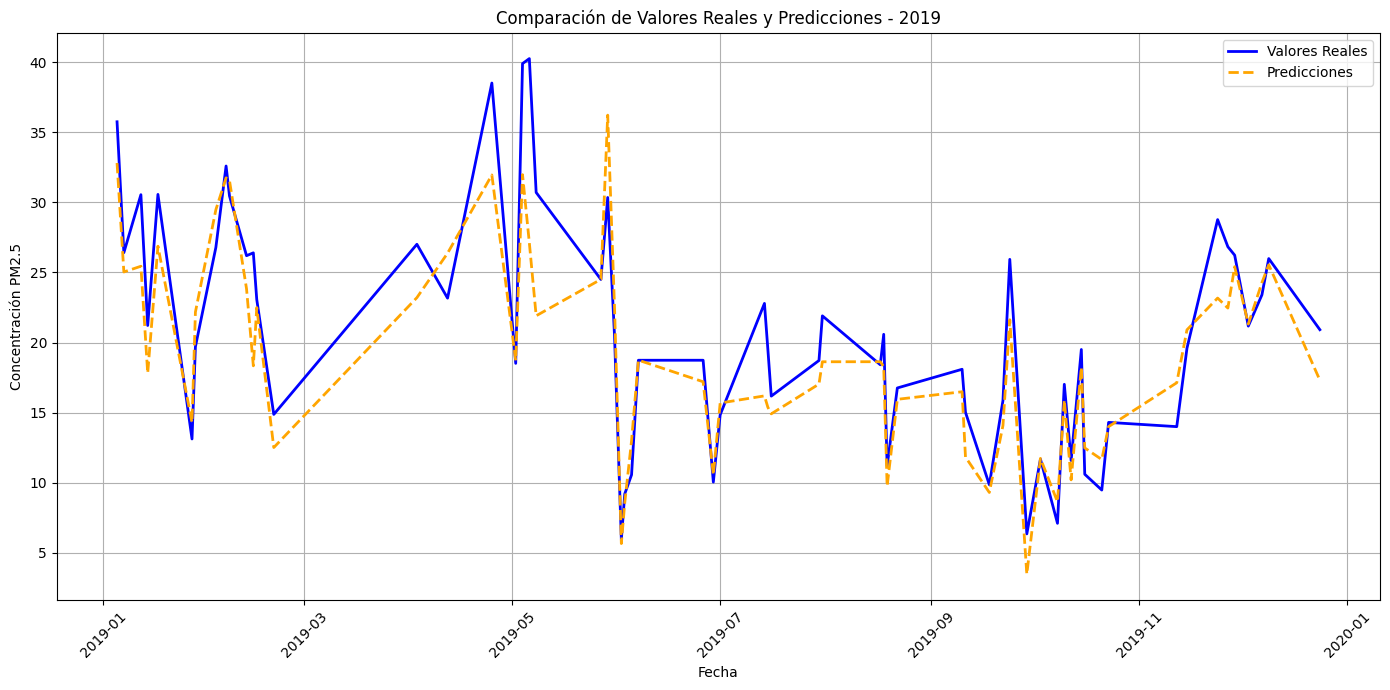

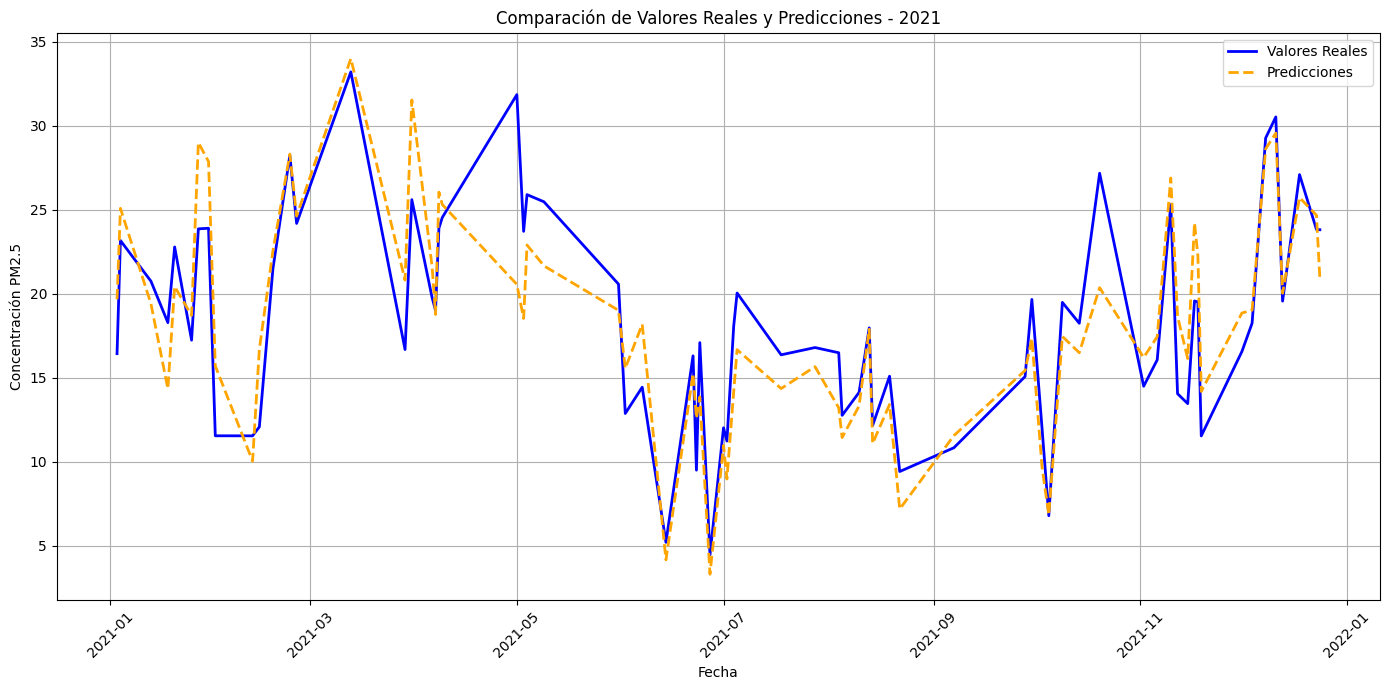

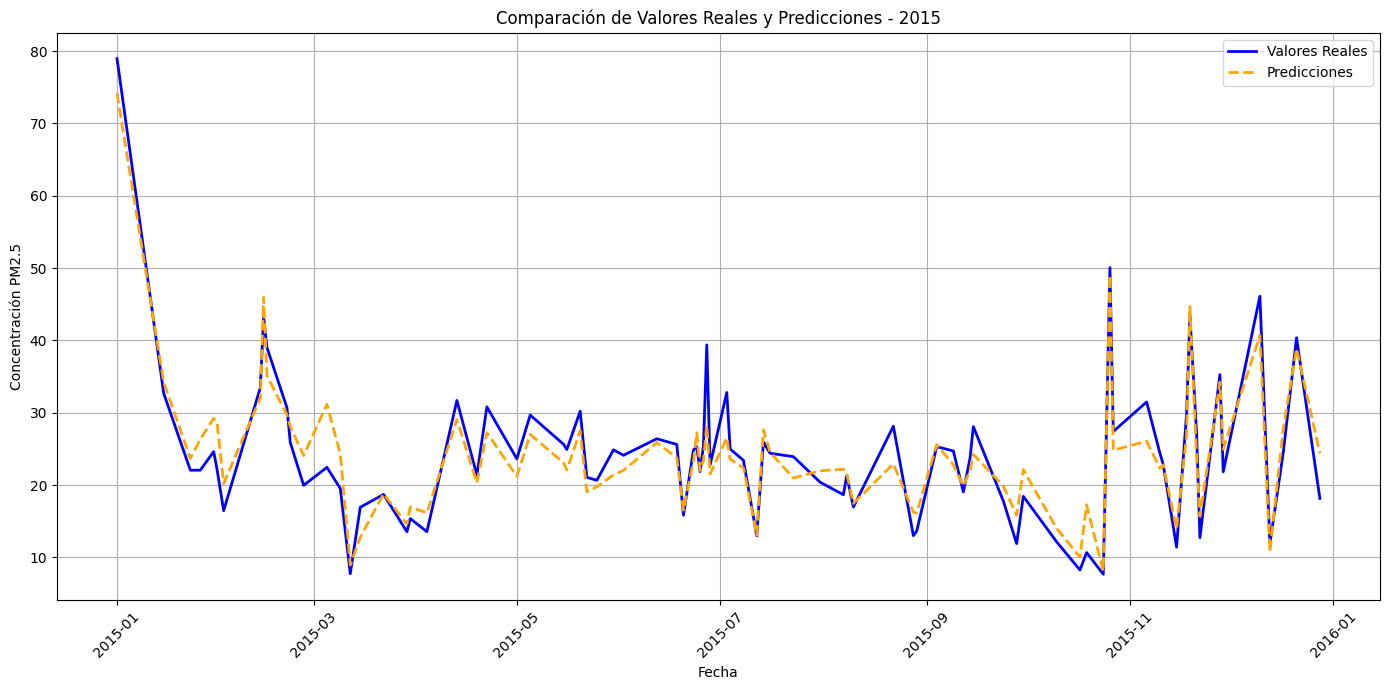

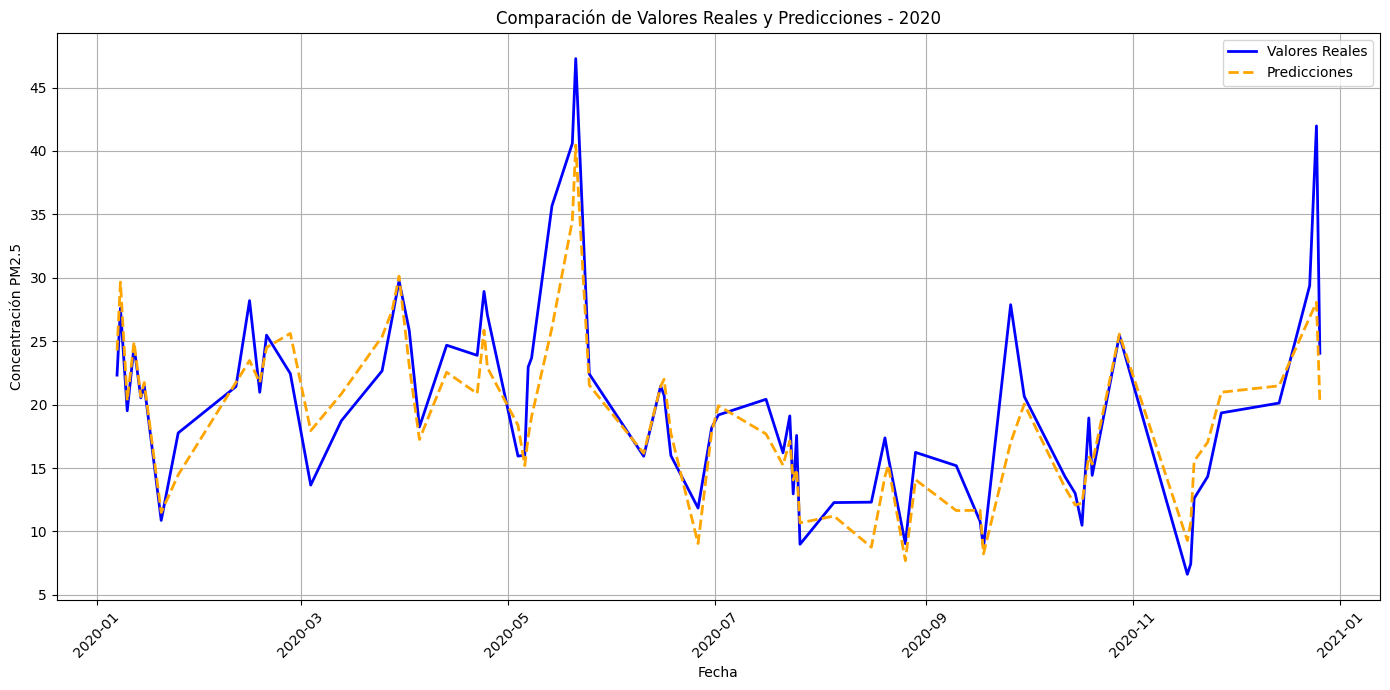

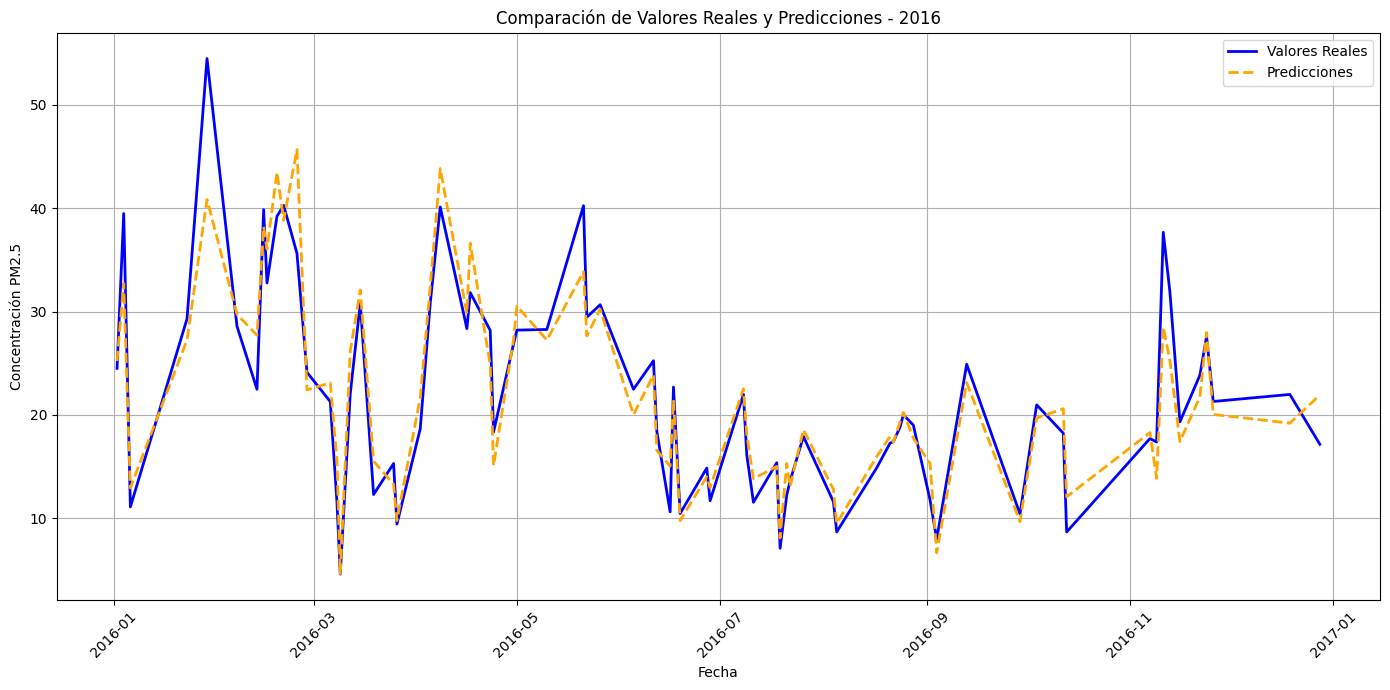

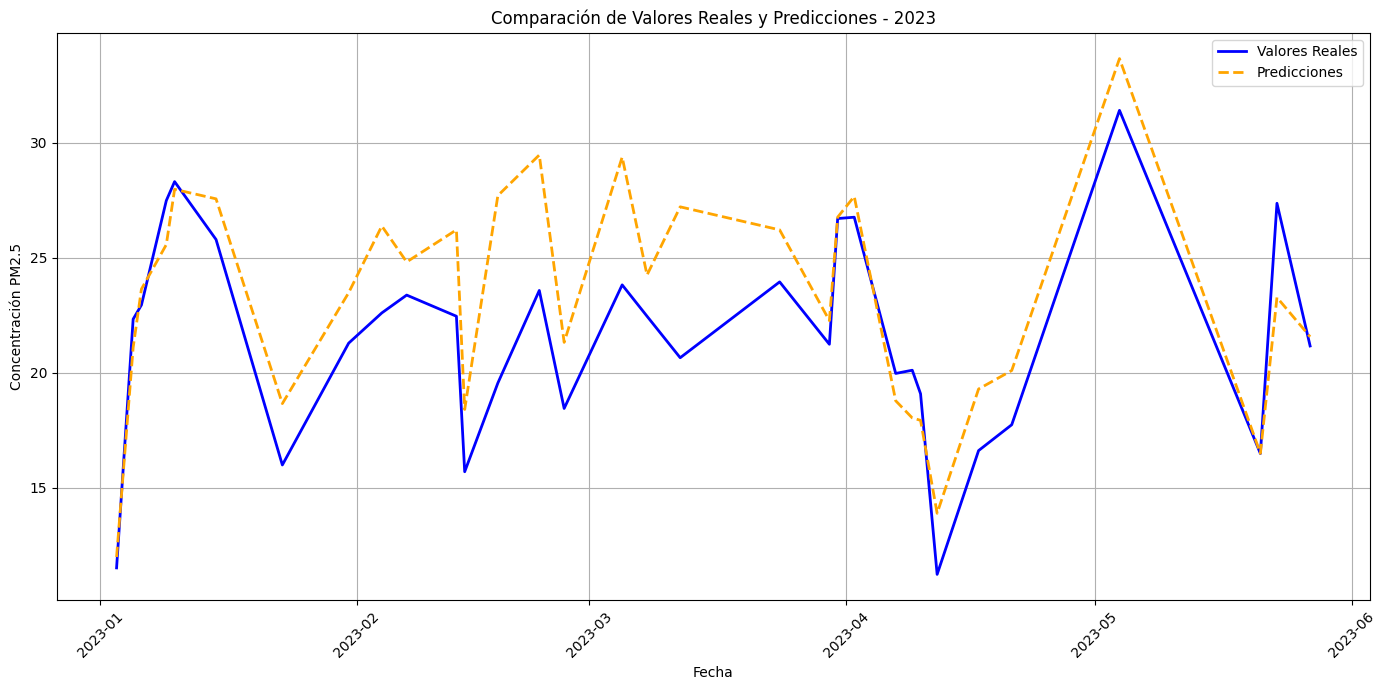

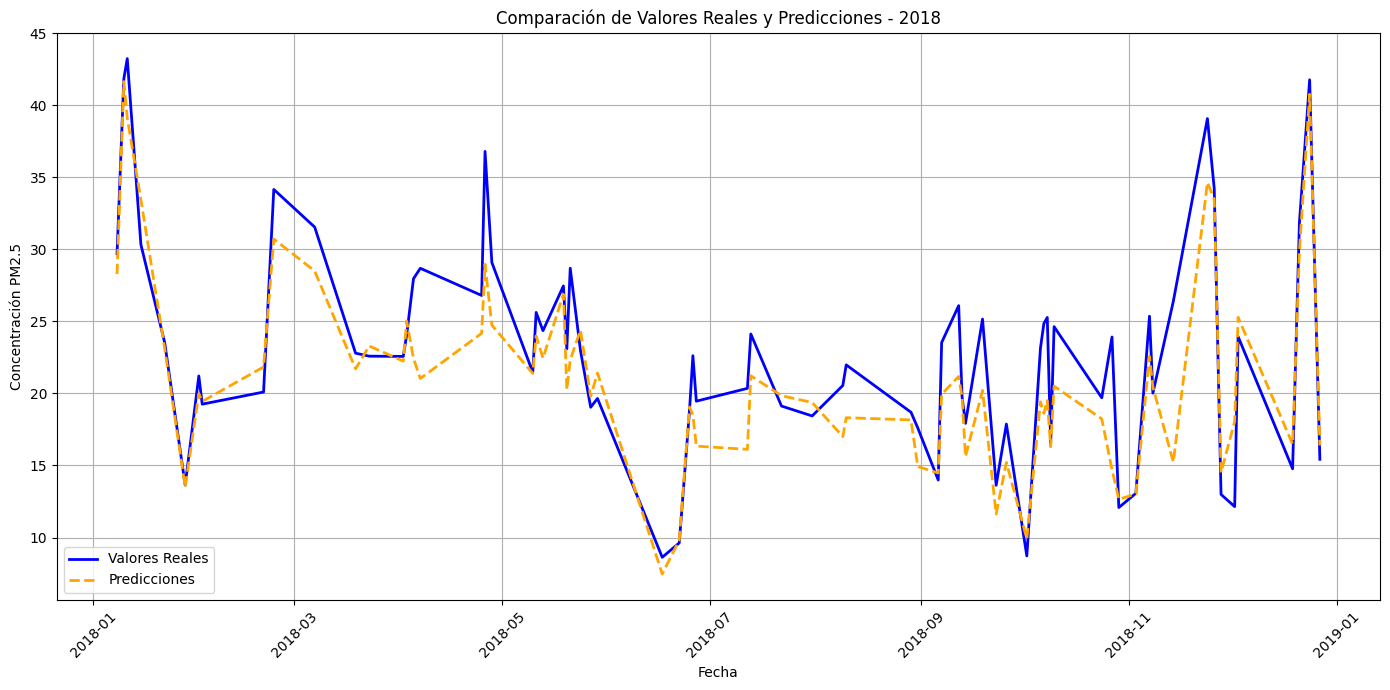

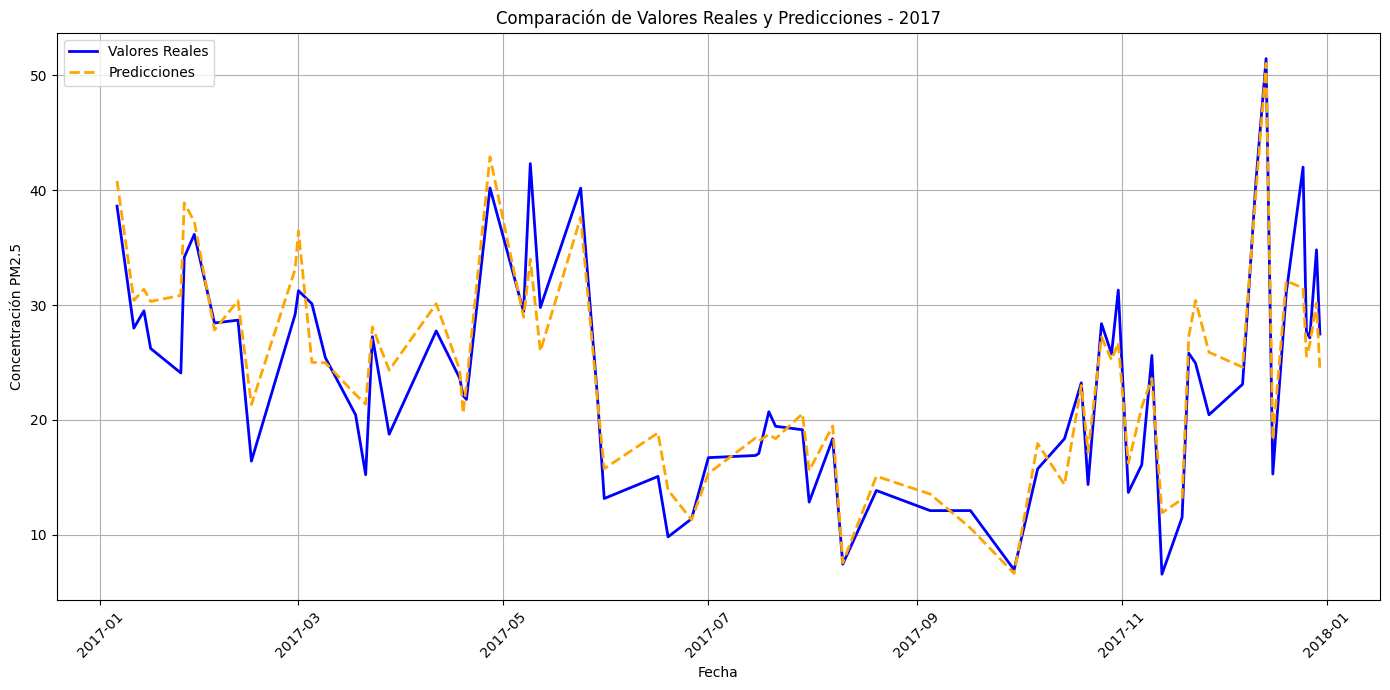

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de que 'fecha' sea de tipo datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Crear un DataFrame para combinar las fechas con los valores reales y predicciones
comparison_df = pd.DataFrame({
    'Fecha': df['fecha'].iloc[y_test.index],
    'Actual': y_test.values,
    'Predicted': y_pred_test
})

# Añadir columna de año
comparison_df['Año'] = comparison_df['Fecha'].dt.year

# Obtener los años únicos en los datos
años = comparison_df['Año'].unique()

# Graficar para cada año
for año in años:
    plt.figure(figsize=(14, 7))
    datos_año = comparison_df[comparison_df['Año'] == año]
    datos_año = datos_año.sort_values('Fecha')  # Ordenar por fecha
    plt.plot(datos_año['Fecha'], datos_año['Actual'], label='Valores Reales', color='blue', linestyle='-', linewidth=2)
    plt.plot(datos_año['Fecha'], datos_año['Predicted'], label='Predicciones', color='orange', linestyle='--', linewidth=2)
    plt.xlabel('Fecha')
    plt.ylabel('Concentración PM2.5')
    plt.title(f'Comparación de Valores Reales y Predicciones - {año}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
# Leer las primeras líneas del archivo para inspeccionar su estructura
with open(file_path, 'r', encoding='latin1') as file:
    lines = [next(file) for _ in range(20)]

# Mostrar las primeras líneas
for line in lines:
    print(line)


INDICE DE CALIDAD DEL AIRE

city: Ciudad de M&eacute;xico

cityCode: MEX

country: M&eacute;xico

mesurementAgency: SIMAT

URL: http://www.aire.cdmx.gob.mx

timeStamp:	2018/01/01 al 2018/12/31

average_interval: 001h

Fecha,Hora,Noroeste Ozono,Noroeste dióxido de azufre,Noroeste dióxido de nitrógeno,Noroeste monóxido de carbono,Noroeste PM10,Noreste Ozono,Noreste dióxido de azufre,Noreste dióxido de nitrógeno,Noreste monóxido de carbono,Noreste PM10,Centro Ozono,Centro dióxido de azufre,Centro dióxido de nitrógeno,Centro monóxido de carbono,Centro PM10,Suroeste Ozono,Suroeste dióxido de azufre,Suroeste dióxido de nitrógeno,Suroeste monóxido de carbono,Suroeste PM10,Sureste Ozono,Sureste dióxido de azufre,Sureste dióxido de nitrógeno,Sureste monóxido de carbono,Sureste PM10,,

01/01/2018,1,24,8,14,12,106,24,5,18,10,108,17,5,21,8,97,22,9,17,8,67,5,5,25,11,94,,

01/01/2018,2,23,8,18,12,107,29,5,16,10,108,21,5,18,8,101,26,9,12,7,70,8,5,21,12,101,,

01/01/2018,3,18,8,19,12,108,23,5,19,11,10

In [ ]:
# Cargar el archivo CSV ignorando las primeras líneas de encabezado
file_path = '/content/indice_2018.csv'
df_2018 = pd.read_csv(file_path, skiprows=8, encoding='latin1', delimiter=',')

# Mostrar las primeras filas del DataFrame para verificar
print(df_2018.head())


        Fecha  Hora  Noroeste Ozono  Noroeste dióxido de azufre  \
0  01/01/2018     1            24.0                           8   
1  01/01/2018     2            23.0                           8   
2  01/01/2018     3            18.0                           8   
3  01/01/2018     4            12.0                          10   
4  01/01/2018     5            11.0                          12   

   Noroeste dióxido de nitrógeno  Noroeste monóxido de carbono  Noroeste PM10  \
0                           14.0                          12.0            106   
1                           18.0                          12.0            107   
2                           19.0                          12.0            108   
3                           18.0                          12.0            110   
4                           18.0                          12.0            113   

   Noreste Ozono  Noreste dióxido de azufre  Noreste dióxido de nitrógeno  \
0           24.0                 

In [ ]:
# Eliminar las columnas sin nombre
df_2018 = df_2018.drop(columns=['Unnamed: 27', 'Unnamed: 28'])

# Crear una columna datetime a partir de Fecha y Hora
df_2018['Fecha'] = pd.to_datetime(df_2018['Fecha'], format='%d/%m/%Y')
df_2018['Hora'] = pd.to_timedelta(df_2018['Hora'], unit='h')
df_2018['datetime'] = df_2018['Fecha'] + df_2018['Hora']

# Eliminar las columnas 'Fecha' y 'Hora'
df_2018 = df_2018.drop(columns=['Fecha', 'Hora'])

# Reordenar las columnas para tener 'datetime' como la primera columna
cols = df_2018.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_2018 = df_2018[cols]

# Mostrar las primeras filas del DataFrame para verificar
print(df_2018.head())


             datetime  Noroeste Ozono  Noroeste dióxido de azufre  \
0 2018-01-01 01:00:00            24.0                           8   
1 2018-01-01 02:00:00            23.0                           8   
2 2018-01-01 03:00:00            18.0                           8   
3 2018-01-01 04:00:00            12.0                          10   
4 2018-01-01 05:00:00            11.0                          12   

   Noroeste dióxido de nitrógeno  Noroeste monóxido de carbono  Noroeste PM10  \
0                           14.0                          12.0            106   
1                           18.0                          12.0            107   
2                           19.0                          12.0            108   
3                           18.0                          12.0            110   
4                           18.0                          12.0            113   

   Noreste Ozono  Noreste dióxido de azufre  Noreste dióxido de nitrógeno  \
0           24.0     

In [ ]:
# Cargar los datos de 2023
df_2023 = pd.read_csv('/content/rama_2023_05.csv')

# Verificar las columnas
print(df_2023.columns)

# Convertir la columna 'fecha' a datetime y manejar los datos sin 'hora'
df_2023['fecha'] = pd.to_datetime(df_2023['fecha'])

# Crear una columna datetime a partir de la columna 'fecha' ya que no tenemos 'hora'
df_2023['datetime'] = df_2023['fecha']

# Eliminar columnas innecesarias y reordenar
df_2023 = df_2023.drop(columns=['fecha'])
df_2023 = df_2023[['datetime'] + [col for col in df_2023.columns if col != 'datetime']]

# Renombrar columnas para que coincidan con los datos de 2018
df_2023 = df_2023.rename(columns={
    'co': 'CO', 'no': 'NO', 'no2': 'NO2', 'nox': 'NOX', 'o3': 'O3', 'pm10': 'PM10', 'pm25': 'PM25', 'so2': 'SO2'
})

# Revisar los primeros registros del DataFrame 2023
print(df_2023.head())



Index(['fecha', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM25', 'SO2'], dtype='object')
    datetime        CO         NO        NO2        NOX         O3  \
0 2015-01-01  1.050696  22.765528  24.225155  46.987578  23.175150   
1 2015-01-02  0.807585  32.249608  21.554160  53.800628  17.268366   
2 2015-01-03  0.640755  21.686916  19.394081  41.071651  15.486486   
3 2015-01-04  0.726940  24.606272  19.560976  44.165505  17.329032   
4 2015-01-05  0.530815  11.443182  20.990260  32.439935  14.470588   

         PM10       PM25        SO2  
0  105.573684  78.953405  11.554723  
1   36.687845  15.449438   1.895052  
2   29.269022  12.915129   1.436937  
3   39.961538  16.838284   1.809061  
4   31.855643  12.667774   8.315789  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Cargar los datos de 2018
file_path_2018 = '/content/indice_2018.csv'
df_2018 = pd.read_csv(file_path_2018, sep=',', encoding='latin1')

# Limpiar los datos de 2018
df_2018.columns =


SyntaxError: invalid syntax (<ipython-input-29-986d97de22f0>, line 14)